<a href="https://colab.research.google.com/github/ChikoAbillaBasya/Pembelajaran-Mesin/blob/main/UTS_2341720005_Chiko_Abilla_Basya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalasi library Annoy untuk Approximate Nearest Neighbor
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 37.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551810 sha256=521bad97c7406bdc8bacc0a96eeb833d698d4f856948b3e474f07eb1cc453dcf
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [2]:
# Instalasi dan Import Library
import kagglehub
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca Dataset
df = pd.read_csv('heart.csv')

# Menampilkan informasi awal dataset
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
# Rekayasa Fitur (Feature Engineering)
# Membuat fitur baru 'CholAge' dengan mengalikan kolom 'chol' dan 'age'
df['CholAge'] = df['chol'] * df['age']
display(df.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,11024
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,10759
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,12180
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,12383
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,18228


### Dataset ini berisi informasi terkait penyakit jantung.

*   **Jumlah Sampel:** Dataset ini memiliki 1025 entri.
*   **Fitur:** Terdapat 14 fitur, termasuk 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', dan variabel target 'target'.
*   **Tipe Data:** Fitur-fiturnya sebagian besar bertipe integer, dengan 'oldpeak' bertipe float.

### Langkah-langkah Pra-pemrosesan

1.  **Penanganan Nilai Kosong:** tidak ada satupun dalam dataset ini.
2.  **Rekayasa Fitur:** Fitur baru 'CholAge' dibuat dengan mengalikan fitur 'chol' dan 'age'.

In [4]:
# Pra-pemrosesan Data

# Mengidentifikasi kolom numerik
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Menghapus kolom 'target' agar tidak ikut dinormalisasi karena merupakan variabel target
if 'target' in numerical_cols:
    numerical_cols.remove('target')

# Membuat objek StandardScaler untuk menormalkan fitur numerik. StandardScaler membuat mean menjadi 0 dan standard deviation menjadi 1.
scaler = StandardScaler()

# Melakukan normalisasi pada kolom numerik yang telah dipilih dan membuat salinan dataframe yang dinormalisasi
df_normalized = df.copy()
df_normalized[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Menampilkan beberapa baris pertama dari dataframe yang sudah dinormalisasi
display(df_normalized.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,0,-0.615014
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,0,-0.681008
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,0,-0.327130
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,0,-0.276576
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,0,1.179033


KMeans Silhouette: 0.13146561834340256
KMeans Davies-Bouldin: 2.313498482762029
DBSCAN Silhouette: 0.9996107278366584
DBSCAN Davies-Bouldin: 0.03066293777761398


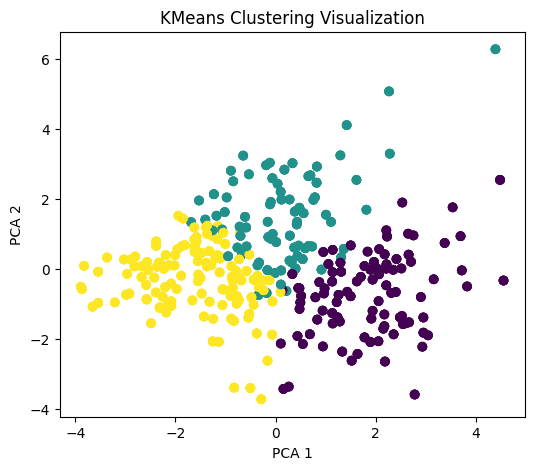

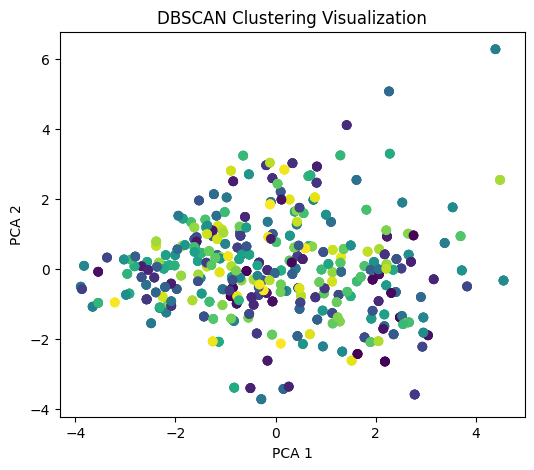

In [5]:
# Clustering Menggunakan K-Means

# Memisahkan fitur dari variabel target untuk clustering
X_scaled = df_normalized.drop('target', axis=1)

# Menerapkan K-Means clustering dengan 3 klaster
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # n_init=10 untuk menjalankan algoritma 10 kali dengan centroid awal yang berbeda
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_ # Mendapatkan label klaster untuk setiap titik data

# Clustering Menggunakan DBSCAN
# Menerapkan DBSCAN clustering. eps adalah jarak maksimum antara dua sampel agar dianggap sebagai satu lingkungan, min_samples adalah jumlah sampel dalam satu lingkungan untuk titik dianggap sebagai titik inti.
dbscan = DBSCAN(eps=0.3, min_samples=3)
labels_dbscan = dbscan.fit_predict(X_scaled) # Mendapatkan label klaster untuk setiap titik data, -1 menunjukkan noise

# Menghitung dan mencetak skor evaluasi clustering (Silhouette Score dan Davies-Bouldin Score)
# Silhouette Score mengukur seberapa mirip objek dengan klaster sendiri dibandingkan dengan klaster lain (nilai lebih tinggi lebih baik)
print("KMeans Silhouette:", silhouette_score(X_scaled, labels_kmeans))
# Davies-Bouldin Score mengukur rasio rata-rata jarak antar klaster terhadap ukuran klaster itu sendiri (nilai lebih rendah lebih baik)
print("KMeans Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_kmeans))

# Mengecek apakah DBSCAN menghasilkan lebih dari satu klaster sebelum menghitung skor (Silhouette dan Davies-Bouldin memerlukan setidaknya 2 klaster)
if len(set(labels_dbscan)) > 1:
    print("DBSCAN Silhouette:", silhouette_score(X_scaled, labels_dbscan))
    print("DBSCAN Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_dbscan))

# PCA (Principal Component Analysis) untuk Reduksi Dimensi menjadi 2 komponen
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) # Menerapkan PCA pada data yang sudah dinormalisasi

# Visualisasi Hasil Clustering K-Means menggunakan 2 komponen PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis') # Membuat scatter plot dengan warna berdasarkan label klaster K-Means
plt.title("KMeans Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Visualisasi Hasil Clustering DBSCAN menggunakan 2 komponen PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='viridis') # Membuat scatter plot dengan warna berdasarkan label klaster DBSCAN
plt.title("DBSCAN Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [6]:
# Implementasi Approximate Nearest Neighbor (Annoy)

# Mendapatkan dimensi (jumlah fitur) dari data yang sudah diskalakan
dim = X_scaled.shape[1]

# Membuat objek Annoy dengan dimensi yang sesuai dan menggunakan metrik Euclidean untuk mengukur jarak
ann = AnnoyIndex(dim, 'euclidean')

# Menambahkan setiap baris data dari X_scaled ke indeks Annoy. add_item(index, vector)
for i in range(len(X_scaled)):
    ann.add_item(i, X_scaled.iloc[i].values)

# Membangun pohon Annoy untuk mempercepat pencarian tetangga terdekat. Semakin banyak pohon, semakin akurat hasilnya, tetapi semakin lambat proses building.
num_trees = 10
ann.build(num_trees)

# Query untuk Mencari Tetangga Terdekat
# Memilih indeks titik data yang akan dijadikan query
query_idx = 42
# Mengambil vektor fitur dari titik data query
query_vector = X_scaled.iloc[query_idx].values

# Menentukan jumlah tetangga terdekat yang ingin dicari
num_neighbors = 5

# Mencari tetangga terdekat dari query_idx menggunakan indeks Annoy. include_distances=True untuk juga mendapatkan jaraknya.
neighbors, distances = ann.get_nns_by_item(query_idx, num_neighbors, include_distances=True)

# Menampilkan hasil pencarian tetangga terdekat
print(f"Query Point Index: {query_idx}")
print("Nearest Neighbors and Distances:")
# Iterasi melalui hasil tetangga dan jaraknya
for n, d in zip(neighbors, distances):
    # Mendapatkan label klaster K-Means untuk tetangga
    cluster_label_kmeans = labels_kmeans[n] if n < len(labels_kmeans) else 'N/A'
    # Mencetak informasi tetangga (indeks, jarak, dan label klaster K-Means)
    print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {cluster_label_kmeans}")

Query Point Index: 42
Nearest Neighbors and Distances:
Neighbor Index: 42 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 670 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 759 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 924 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 96 | Distance: 1.4560 | Cluster (KMeans): 1
